In [35]:
try:
    from eunjeon import Mecab
    import eunjeon
except:
    from konlpy.tag import Mecab
import konlpy

# numpy & pandas
import numpy as np
import pandas as pd

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Embedding, Activation, LSTM, Bidirectional, GRU, Softmax, Dropout, Flatten
from keras.preprocessing.sequence import pad_sequences

# my lib
import textlib as tl
import Word2VecModel as wv

In [55]:
#w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_w2v_alltag/telco_w2v_'
#w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_'
w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_'
is_all_tag = True

In [56]:
# 여러개의 w2v 모델을 만들기 위한 table
MODEL_COUNT = 9
MODEL_NAMES = ['V10000_E128_W3','V10000_E128_W4','V10000_E128_W5',
               'V10000_E256_W3','V10000_E256_W4','V10000_E256_W5',
               'V10000_E384_W3','V10000_E384_W4','V10000_E384_W5']

In [38]:
# loss, accuracy plot
def plot_hist(hist):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2)
    loss_ax = axes[0]
    acc_ax = axes[1]

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower right')

    plt.show()    

In [57]:
# sop dataset 읽어옴
input_file_name = '../TCL2021_Telco_Embedding_Dataset/dataset/sop_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')

print( df.shape )


(65635, 6)


In [6]:
# null 인 row가 하나라도 있으면 삭제
df.dropna(axis=0, inplace=True)
print( df.shape )

(65635, 6)


In [40]:
# dataset의 문장 길이 통계
def avg(it):
    return sum(it) / len(it)

lens = [len(s) for s in df['sentence'].values]
#lens = [len(s) for s in X]

print( min(lens) )
print( max(lens) )
print( avg(lens) )

34
3222
295.5143749523882


In [58]:
# 임시 로직. 나중에 dataset 생성기에 적용 !
def conv_label(label_):
    if label_ == 'SWING 재무/정산':
        return 'SWING Payment'
    elif label_.find('CTC') >= 0:        
        return 'SWING CTC'
    else:
        return label_    

df['label_clean'] = df['label_clean'].apply(conv_label)

In [59]:
# label 통계
df.groupby('label_clean').count()

,담당BA부서,date,co,sentence,label_org
label_clean,,,,,
MPAMS,333,333,333,333,333
MVNO,380,380,380,380,380
SKT eService-Tsales,98,98,98,98,98
SWING CTC,4623,4623,4623,4623,4623
SWING DBM,408,408,408,408,408
SWING NIS,385,385,385,385,385
SWING Payment,6463,6463,6463,6463,6463
SWING Portal,203,203,203,203,203
SWING SSO,403,403,403,403,403


In [60]:
# 첫 모델은 sentence와 label만 써보자
# df_zip = df[ ['sentence', 'label'] ]

y = df.pop('label_clean')
X = df.pop('sentence')

In [61]:
# 문자열로 되어 있는 label을 categorical value로 변환
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

In [62]:
# 잘 변환됐나?
print( y )
print( label_encoder.inverse_transform(y) )

[ 3 24  6 ...  6 20 32]
['SWING CTC' 'SWING 파트너관리(PRM)' 'SWING Payment' ... 'SWING Payment'
 'SWING 자원 - 계약서관리' '상품-무선']


In [63]:
w2v_model = wv.Word2VecModel()
w2v_model.load(w2v_model_file_name_prefix + MODEL_NAMES[2])
print(f'{w2v_model_file_name_prefix + MODEL_NAMES[2]} loaded')

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E128_W5 loaded


In [64]:
# 전처리 테스트
print('--- raw sentence ---')
print( X[0] )
print()

print('--- 클렌징된 sentence ---')
cleansed_text = tl.clean_text( X[0] )
print( cleansed_text )
print()

print('--- 구두점 단위로 잘라서 배열화 ---')
tokenized_sentence = tl.segment_sentences(cleansed_text)
print( tokenized_sentence )
print()

print('--- 형태소 ---')
# SOR이니까 변경/요청 이란 단어는 항상 들어가므로 삭제
#ignore_words = ['변경','요청','SWING']
corpora = ' '.join(tl.get_corpora(sentences=tokenized_sentence,
                                  ignore_words=[],
                                  tagger=None,
                                  isAllTag=is_all_tag)).split(' ')
print(corpora)
print()

sequence = w2v_model.get_words_indexes(corpora)
print('word id')
print(sequence)
print()

print(y[0])
print(label_encoder.inverse_transform([y[0]]))


--- raw sentence ---
[Swing]고객상담]_상담예약 한적없으나 SMS 수신 되어 문의 . [Swing]고객상담]_상담예약 한적없으나 SMS 수신 되어 문의

010-9425-6450==970627


통합접척이력 조회> SMS/MMS 수신 2019-05-28 :15:45 
[SKT] 16시 상담예약 완료.
01094256450
으로 전화드리겠습니다.

SMS 수신되어 확인 부탁 드립니다

해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다 

요청자  최 문경 : 010-4035-3522

--- 클렌징된 sentence ---
 Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의 . Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의

 


통합접척이력 조회 SMS/MMS 수신 
 SKT 시 상담예약 완료.
 
으로 전화드리겠습니다.

SMS 수신되어 확인 부탁 드립니다

해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다 

요청자 최 문경 

--- 구두점 단위로 잘라서 배열화 ---
['Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의', 'Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의', '통합접척이력 조회 SMS/MMS 수신', 'SKT 시 상담예약 완료', '으로 전화드리겠습니다', 'SMS 수신되어 확인 부탁 드립니다', '해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다', '요청자 최 문경']

--- 형태소 ---
['Swing', '고객', '상담', '_', '상담', '예약', '한', '적', '없', '으나', 'SMS', '수신', '되', '어', '문의', 'Swing', '고객', '상담', '_', '상담', '예약', '한', '적', '없', '으나', 'SMS', '수신', '되', '어', '문의', 

In [65]:
# raw 문장을 전처리(쪼개고 형태소로 분리하고 단어id로 바꾸고 padding까지)
def preprocess_sentence(X, w2v_model, max_sentence_len=256, ignore_words=[]):
    # 문장 전처리
    preprocessed_X = []
    print(f'{len(X)} 개의 데이터 존재 확인!')

    for i, text in enumerate(X):
        try:
            # 클렌징
            cleansed_text = tl.clean_text(text)
        except TypeError:
            print(f'      {i+1} 번째 데이터에 문제가 있어 skip!')
            continue

        # 문장으로 분리하여 배열로 리턴
        sentences = tl.segment_sentences(cleansed_text)
        # 문장 배열을 입릭으로 받아 형태소로 쪼갠 뒤, 다시 하나의 문자열로 변환하여 저장
        corpora = ' '.join(tl.get_corpora(sentences, ignore_words)).split(' ')
        # 단어들을 id로 변환
        sequence = w2v_model.get_words_indexes(corpora)
        
        preprocessed_X.append(sequence)

        if i % 5000 == 0 and i > 0:
            print(f'      {i} 번째 데이터 처리 완료!')

    print('데이터 전체 처리 완료!')
    # 최대 길이까지만 문장 사용. 짧은 문장은 뒤쪽에 PADDING token으로 채워서 리턴
    preprocessed_X = pad_sequences( preprocessed_X, 
                                   maxlen=max_sentence_len, 
                                   padding='post', 
                                   value=w2v_model.word2index[wv.PAD_TOKEN] )
    print('PADDING 완료!')    
    return preprocessed_X
    

In [66]:
MAX_SENTENCE_LEN = 256
preprocessed_X = preprocess_sentence(X, w2v_model, MAX_SENTENCE_LEN, [])

65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!


In [67]:
# train / test 분리
X_train, X_test, y_train, y_test = \
    train_test_split(preprocessed_X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
# 배열을 numpy 로 변경
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)

print( len(X_train) )
print( len(X_test) )
print( len(y_train) )
print( len(y_test) )

52508
13127
52508
13127


In [69]:
X_train.shape

(52508, 256)

In [70]:
# DL 모델. 
class SOPClassifier(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, hidden_dim,
                 batch_size, embedding_weights, train_embedding_layer, dropout, classes):
        super(SOPClassifier, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_weights])
        self.lstm = Bidirectional( LSTM(self.dec_units) )
        self.fc1 = Dense(hidden_dim, activation='relu')
        self.fc2 = Dense(hidden_dim, activation='relu')        
        self.fc3 = Dense(classes, activation='softmax')
        self.do1 = Dropout(dropout)
        self.do2 = Dropout(dropout)
        self.do3 = Dropout(dropout)
        
        self.embedding.trainable = train_embedding_layer
        
    # 단어id 벡터 -> embedding layer -> bilstm -> dropout -> (opt)attention -> fc -> droupout -> fc(softmax)

    def call(self, x):
        # (batch, seq) -> (batch, seq, embedding_dim)        
        x = self.embedding(x)

        # (batch, seq, embedding_dim) -> (batch, seq, embedding_dim*2)        
        x = self.lstm(x)
        x = self.do1(x)        

        # (batch, embedding_dim) -> (batch, 128)    
        x = self.fc1(x)
        x = self.do2(x)
        x = self.fc2(x)
        x = self.do3(x)
        x = self.fc3(x)
        
        return x


In [71]:
def train_and_evaluate(vocab_size, embedding_dim, dec_units, hidden_units, epochs, batch_size, 
       weights, train_embedding_layer, dropout, classes):
    model = SOPClassifier(
        vocab_size, 
        embedding_dim, 
        dec_units, 
        hidden_units,
        batch_size,
        weights,
        train_embedding_layer,
        dropout,
        classes
    )

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    test_score = model.evaluate(X_test, y_test, verbose=2)
    
    plot_hist(history)
    
    return model, history, test_score

-----------------True-128-False-0.5----------------
Epoch 1/10
657/657 [==============================] - 60s 82ms/step - loss: 1.3087 - accuracy: 0.6665 - val_loss: 0.8021 - val_accuracy: 0.7823
Epoch 2/10
657/657 [==============================] - 49s 75ms/step - loss: 0.9044 - accuracy: 0.7622 - val_loss: 0.7268 - val_accuracy: 0.7953
Epoch 3/10
657/657 [==============================] - 50s 75ms/step - loss: 0.7862 - accuracy: 0.7887 - val_loss: 0.6825 - val_accuracy: 0.8039
Epoch 4/10
657/657 [==============================] - 50s 75ms/step - loss: 0.7234 - accuracy: 0.8032 - val_loss: 0.6529 - val_accuracy: 0.8149
Epoch 5/10
657/657 [==============================] - 50s 76ms/step - loss: 0.6761 - accuracy: 0.8151 - val_loss: 0.6541 - val_accuracy: 0.8178
Epoch 6/10
657/657 [==============================] - 50s 76ms/step - loss: 0.6344 - accuracy: 0.8267 - val_loss: 0.6339 - val_accuracy: 0.8180
Epoch 7/10
657/657 [==============================] - 50s 77ms/step - loss: 0.6032 -

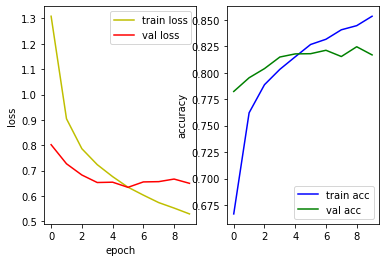

INFO:tensorflow:Assets written to: ./model/True-128-False-0.5\assets


INFO:tensorflow:Assets written to: ./model/True-128-False-0.5\assets


In [72]:
hyper_params = {
    'train_embedding_layer': [False],
    'dropout': [0.5]
}

histories = dict()
test_scores = dict()

EPOCHS=10
BATCH_SIZE = 64

for te in hyper_params['train_embedding_layer']:
    for do in hyper_params['dropout']:
        vocab_size, embedding_dim = w2v_model.weight.shape
        model_name = f'{is_all_tag}-{embedding_dim}-{te}-{do}'
        print('-----------------' + model_name + '----------------')
        model, history, test_score = \
            train_and_evaluate(vocab_size, 
                               embedding_dim,
                               256,
                               256,
                               EPOCHS,
                               BATCH_SIZE,
                               w2v_model.weight,
                               te, # embedding layer를 훈련시킬지, freezing시킬지?
                               do, # dropout 비율
                               len(label_encoder.classes_)) # class 개수

        histories[model_name] = history
        test_scores[model_name] = test_score
        model.save(f'./model/{model_name}')

In [23]:
for x, e, r in zip(X_test, np.argmax(model.predict(X_test),-1), y_test):
    if e != r:
        print(' '.join([w2v_model.index2word[t] for t in x]))
        print(label_encoder.inverse_transform([e,r]))
        print('-' * 6)


OSS 시설 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 확인 불가 심사 접수 취소 문의 OSS 시설 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 확인 불가 심사 접수 취소 문의 화면 명 통합 접촉 이력 조회 서비스 번호 주소 서울 해 등 호 장애 현상 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 센터 <UNK> 수건 확인 불가 심사 접수 취소 문의 문 <UNK> 미가 심사 등록 문의 확인 티켓 종료 부탁 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

['SWING Payment' '인터페이스(SMS,MMS포함)']
------
CRM 캠페인 이번 달 약정 만료 고객 캠페인 문자 수신 것 확인 해당 고객 발신 이력 확인 문의 화면 명 서비스 번호 연락처 주소 장애 현상 CRM 캠페인 이번 달 약정 만료 고객 캠페인 문자 수신 것 확인 해당 고객 발신 이력 확인 문의 고객 수신 문 Swing MMS GW 전송 캠페인 번호 ABB ABB MMS GW 고객 전송 결과 확인 필요 MMS GW 부서 문 주신 대상 저희 쪽 발송 이력 확인 확인 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

OSS 시설 건물 가용 정보 조회 유선 화면 내 주소 사용 서비스 조회 외국인 사용 확인 문의 화면 명 건물 가용 정보 조회 유선 서비스 번호 주소 서울 노원구 한글 <UNK> 길 호 장애 현상 OSS 시설 건물 가용 정보 조회 유선 화면 내 주소 사용 서비스 조회 건물 거주 외국인 사용 서비스 번호 확인 문의 외국인 서비스 번호 <UNK> 시작 서비스 번호 확인 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['SWING 유선오더' 'SWING CTC']
------
상품 관리 선택 약정 선택 약정 승계 후 취소 선택 약정 입시 지원금 가입 불가 문의 선택 약정 승계 후 취소 선택 약정 입시 지원금 가입 불가 문의 SM J <UNK> 가입 당시 단말기 사용 중 확인 부탁 요청 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

['SWING 오더 - 무선오더' 'T gate']
------
빌링 청구 요금 조정 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 빌링 청구 요금 조정 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 화면 명 청구 수납 관리 서비스 번호 장애 현상 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['상품-단말기' 'SWING 청구']
------
긴급 청구 청구 내역 월 일 월 수납 국제 전화 요금 언제 사용 청구 문의 화면 명 서비스 번호 증상 오류 메시지 청구 수납 관리 화면 서비스 조회 시 수납 환불 내역 탭 월 수납 원 월 수납 원 확인 개회 선 해당 금액 언제 언제 사용 요금 확인 부탁 요청 차 효정 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['SWING SSO' 'SWING Portal']
------
차 접수 공통 기준 정보 일 이후 결합 가능 권한 센터 부여 확인 특정 상담원 해당 업무 불가 문의 공통 기준 정보 일 이후 결합 가능 권한 센터 부여 확인 특정 상담원 해당 업무 불가 문의 ER 동일 문 의건 결합 진행 중 처리 문의 화면 명 결합 상품 상담원 ID <UNK> B 장애 현상 해당 상담원 TB 가족 프리 가족 할인 TV 플러스 유선 일 제한 예외 권 부여 조직 소속 해당 결합 업무 진행시 서비스 가입 일 개통 가능 제한 이후 확인 문의 조직 권한 권한 적용 개별 권한 신청 지 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



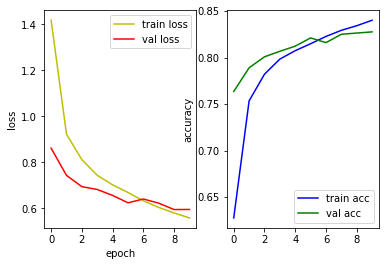

In [53]:
plot_hist(histories['True-128-False-0.5'])

In [73]:
test_scores

{'True-128-False-0.5': [0.6411054134368896, 0.820903480052948]}

# w2v
## 384-all-5 -> 83.964...
## 384-일부-5 -> 83.82...
## 128-all-5 -> 83.088...


# fasttext
## 128-all-5  -> 82.09